In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import scipy
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose, LocallyConnected2D,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture


/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 2, 2, 3
original_img_size = (img_rows, img_cols, img_chns)
num_samples = 1000

batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 1))
n_components = int(os.environ.get('MIXTURE_COMPONENTS', 10))

# Generate a dataset based on mixtures of logistic

Scaling and shifting a logistic: http://www.math.wm.edu/~leemis/chart/UDR/PDFs/LogisticS.pdf


X ~ Logistic(m, s)

Y = cX

then:

Y ~ Logistic(m, s*c)

In [3]:
np.random.seed(127)

# logistic std deviation of 1 pixel level
unit_s = 1 / math.pi * math.sqrt(3)

def train_data_simple(num_samples):
    # Generate pixels using exactly 2 mixture components
    n_comp = 2
    
    # Each pixel is a independent single logstic
    X_train = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Set the distribution values to fixed values so we can tell the difference
    m = np.array([
        [
            [[10.,  250.],  [10, 250.],  [10, 250.]],
            [[10.,  250.],  [10., 10. ], [10., 10.]]
        ], 
        [
            [[10.,  100.],  [10., 250. ], [10., 10.]], 
            [[10.,  10.],  [10., 10. ], [10., 250.]]
        ], 
    ])
    s = 10 * unit_s * np.ones((img_rows, img_cols, img_chns, n_comp))
    w = np.ones((img_rows, img_cols, img_chns, n_comp))
    w = w / w.sum(axis=3)[:, :, :, np.newaxis]
    
    #m = np.random.normal(127.5, 40, (img_rows, img_cols, img_chns, n_comp))
    #s = np.random.uniform(1 * unit_s, 40 * unit_s, (img_rows, img_cols, img_chns, n_comp))
    #
    ## Each row has same mxiture weight
    #w = np.random.randint(1, 10, (img_rows, img_cols, img_chns, n_comp))
    #w = w / w.sum(axis=3)[:, :, :, np.newaxis]
    
    for n in range(num_samples):
        for i in range(img_rows):
            for j in range(img_cols):
                for k in range(img_chns):
                    pixels = []
                    for c in range(n_comp):
                        pixels.append(np.random.logistic(m[i, j, k, c], s[i, j, k, c], 1))
                    index = np.argmax(np.random.multinomial(1, w[i, j, k])) 
                    X_train[n, i, j, k] = max(min(int(pixels[index]), 255), 0)
                
    print('Logistic m:')
    print((m - 127.5) / 127.5)
    print('Logistic s')
    print(np.log(127.5 / s))
    print('Mixture w')
    print(w)
    return X_train, (m, s, w)

X_train, params = train_data_simple(num_samples)
X_train = (X_train - 127.5) / 127.5
print(X_train.shape)
#print(params)

Logistic m:
[[[[-0.92156863  0.96078431]
   [-0.92156863  0.96078431]
   [-0.92156863  0.96078431]]

  [[-0.92156863  0.96078431]
   [-0.92156863 -0.92156863]
   [-0.92156863 -0.92156863]]]


 [[[-0.92156863 -0.21568627]
   [-0.92156863  0.96078431]
   [-0.92156863 -0.92156863]]

  [[-0.92156863 -0.92156863]
   [-0.92156863 -0.92156863]
   [-0.92156863  0.96078431]]]]
Logistic s
[[[[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]

  [[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]]


 [[[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]

  [[3.14095501 3.14095501]
   [3.14095501 3.14095501]
   [3.14095501 3.14095501]]]]
Mixture w
[[[[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]

  [[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]]


 [[[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]

  [[0.5 0.5]
   [0.5 0.5]
   [0.5 0.5]]]]
(1000, 2, 2, 3)


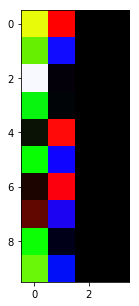

In [4]:
n = min(num_samples, 5)
figure = np.zeros((img_rows * n, img_cols * 2, img_chns)).astype(int)
for i in range(n):
    orig_img = (X_train[i] * 127.5 + 127.5).astype(int)
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = orig_img
    
    # Digitize
    #img = orig_img #.astype(float) / 255
    #figure[dy:dy + img_rows, img_cols:2 * img_cols] = img

plt.figure(figsize=(n * 4, 5))
plt.imshow(figure)
plt.show()

In [5]:
X_train[15,:]

array([[[-1.        , -0.8745098 ,  0.94509804],
        [ 1.        , -0.85098039, -0.95294118]],

       [[-0.9372549 ,  0.99215686, -0.94509804],
        [-0.96078431, -0.96078431,  0.85882353]]])

# Pixel CNN Helpers

# Model

In [6]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1

In [7]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

main_input = Input(shape=original_img_size, name='main_input')

ms = []
invss = []
weights = []
for channel in range(img_chns):
    x = Lambda(lambda x: x * 0.)(main_input)
    x = Flatten()(x)
    decoder_out_m_ = Dense(img_rows * img_cols * n_components, name='x_m' + str(channel),
                           bias_initializer='glorot_uniform')(x)
    decoder_out_m_ = Lambda(lambda x: x)(decoder_out_m_)
    decoder_out_m = Reshape((img_rows, img_cols, n_components))(decoder_out_m_)
    ms.append(decoder_out_m)
    
    decoder_out_invs_ = Dense(img_rows * img_cols * n_components, name='x_s' + str(channel),
                              activation='sigmoid', bias_initializer='glorot_uniform')(x)
    decoder_out_invs = Lambda(lambda x: 5. * x + 2)(decoder_out_invs_)
    decoder_out_invs = Reshape((img_rows, img_cols, n_components))(decoder_out_invs)
    
    invss.append(decoder_out_invs)
   
    x_reshape = Reshape((img_rows, img_cols, img_chns))(x)
    mixture_weights = LocallyConnected2D(name='weights' + str(channel),
                                         filters=n_components, kernel_size=1, strides=1,
                                         bias_initializer='ones')(x_reshape)
    weights.append(mixture_weights)

out_m = Concatenate()(ms)
out_invs = Concatenate()(invss)
out_weights = Concatenate()(weights)
main_output = Concatenate()([out_m, out_invs, out_weights])

In [8]:
print("Building model...")
optimizer = RMSprop(lr=0.001)

model = Model(inputs=main_input, outputs=main_output)
model.compile(optimizer=optimizer, loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, n_components))
model.summary()

Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 2, 2, 3)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 2, 2, 3)      0           main_input[0][0]                 
___________________________________________________________________________________________

In [9]:
start = time.time()


early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_test_loss_mixture/base', histogram_freq=1, batch_size=1, write_graph=True, 
                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=40,
    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
    #validation_data=(X_train, X_train),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  70.30866622924805


,loss,lr
count,9.000000,9.000
mean,68.055068,0.001
std,32.022447,0.000
min,56.181812,0.001
0%,56.181812,0.001
25%,56.217786,0.001
50%,56.388620,0.001
75%,57.744103,0.001
95%,117.344875,0.001
99%,146.040442,0.001


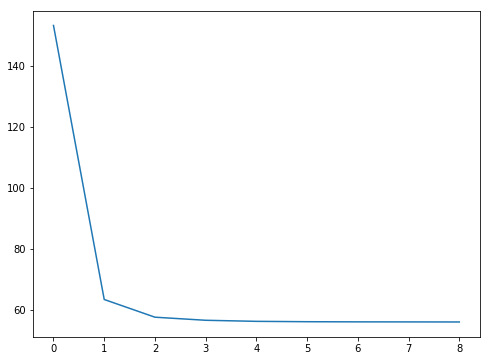

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [11]:
lossvals = model.evaluate(X_train, X_train)
print(lossvals)

1000/1000 [==============================] - 0s 233us/step
1785.8868330078126


# Generate Some Images

(2, 2, 3)
==== 0 0 0
 m:  [-0.02698147  0.01462236 -0.92625135 -0.92608273  0.95865643  0.95864004
 -0.92726487 -0.2762249  -0.29383242 -0.85962117]
 param_m:  [-0.92156863  0.96078431]
 E[m]:  0.07353799
 invs:  [4.6700015 3.9699352 3.263553  3.7628102 3.2500765 3.2486928 3.1998398
 4.2043867 4.9353404 4.550929 ]
 param_invs:  [3.14095501 3.14095501]
 weights:  [2.3930288e-05 2.3930288e-05 4.3166429e-01 3.5018637e-03 3.4083211e-01
 1.8954945e-01 3.3888154e-02 2.3930288e-05 2.3930288e-05 4.6846978e-04]
 param_weight:  [0.5 0.5]
 pvals:  0      0.065359
1      0.012360
2      0.014171
3      0.016050
4      0.017929
5      0.019719
6      0.021319
7      0.022626
8      0.023541
9      0.023991
10     0.023939
11     0.023388
12     0.022387
13     0.021015
14     0.019374
15     0.017572
16     0.015708
17     0.013860
18     0.012077
19     0.010399
240    0.011552
241    0.013392
242    0.015366
243    0.017426
244    0.019502
245    0.021502
246    0.023323
247    0.024853
248    0.

==== 1 0 2
 m:  [ 0.268583    0.428555    0.03064537  0.2275523  -0.2516753  -0.9328428
 -0.22948551  0.25807273  0.28130144  0.5757891 ]
 param_m:  [-0.92156863 -0.92156863]
 E[m]:  -0.9326105
 invs:  [4.917855  3.9352956 4.6672616 4.651613  5.0634604 3.2011693 5.197523
 4.3363533 4.9981375 4.775869 ]
 param_invs:  [3.14095501 3.14095501]
 weights:  [2.3256514e-05 2.3256514e-05 2.3256514e-05 2.3256514e-05 2.3256514e-05
 9.9979067e-01 2.3256514e-05 2.3256514e-05 2.3256514e-05 2.3256514e-05]
 param_weight:  [0.5 0.5]
 pvals:  0     0.174594
1     0.029519
2     0.033075
3     0.036590
4     0.039913
5     0.042874
6     0.045302
7     0.047040
8     0.047971
9     0.048026
10    0.047203
11    0.045560
12    0.043210
13    0.040307
14    0.037020
15    0.033520
16    0.029961
17    0.026473
18    0.023153
19    0.020069
20    0.017262
21    0.014749
22    0.012530
23    0.010593
dtype: float64
 pixel_val:  6
==== 1 1 0
 m:  [-0.48981115  0.09500539  0.63069487 -0.8535477  -0.03636081 -0

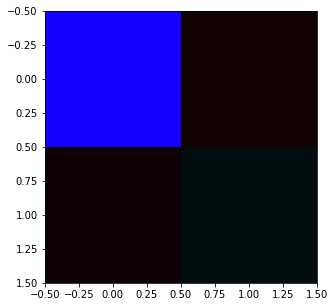

Orig: 


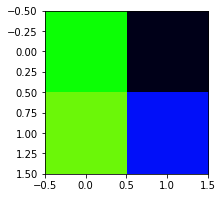

Elapsed:  6.422557592391968


In [15]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * n_components
                    x_ms = x_out[n, i, j, offset:offset + n_components]
                    offset = n_components * img_chns + k * n_components
                    x_invs = x_out[n, i, j, offset:offset + n_components]
                    offset = 2 * n_components * img_chns + k * n_components
                    weights = softmax(x_out[n, i, j, offset:offset + n_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, n_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val / 255.
                    if 0 <= i <= 1 and 0 <= j <= 1 and debug:
                        print("====", i, j, k)
                        print(" m: ", x_ms)
                        print(" param_m: ", (params[0][i, j, k] - 127.5) / 127.5)
                        print(" E[m]: ", (x_ms * weights).sum())
                        print(" invs: ", x_invs)
                        print(" param_invs: ", np.log(127.5 / params[1][i, j, k]))
                        print(" weights: ", weights)
                        print(" param_weight: ", params[2][i, j, k])
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #assert False
        if debug:
            print("row", i)
                
    return x_sample


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * n, img_chns))
print(figure.shape)
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
print("Generated: ", elapsed)
plt.figure(figsize=(5, 5))
plt.imshow(figure)
plt.show()

print("Orig: ")
plt.figure(figsize=(3, 3))
plt.imshow(orig_img)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

# Validatation

Check that we were able to approximately recover the original distributions

[-0.92156863  0.96078431] [3.14095501 3.14095501] [0.5 0.5]
[-0.02698147  0.01462236 -0.92625135 -0.92608273  0.95865643  0.95864004
 -0.92726487 -0.2762249  -0.29383242 -0.85962117] [4.6700015 3.9699352 3.263553  3.7628102 3.2500765 3.2486928 3.1998398
 4.2043867 4.9353404 4.550929 ] [2.3930288e-05 2.3930288e-05 4.3166429e-01 3.5018637e-03 3.4083211e-01
 1.8954945e-01 3.3888154e-02 2.3930288e-05 2.3930288e-05 4.6846978e-04]
KL Divergence(orig, gen) for (0,0,0): 0.01
[-0.92156863  0.96078431] [3.14095501 3.14095501] [0.5 0.5]
[-0.9364088  -0.04315373 -0.09889376 -0.04124939  0.05244303 -0.02865618
 -0.28646803 -0.9301526   0.46761993  0.96537507] [3.1351786 3.7044966 4.8577785 4.7931647 4.604888  4.3268704 4.3221283
 3.2689004 4.756758  3.234819 ] [1.2146860e-02 2.3938917e-05 2.3938917e-05 2.3938917e-05 2.3938917e-05
 2.3938917e-05 2.3938917e-05 4.8368439e-01 2.3938872e-05 5.0400132e-01]
KL Divergence(orig, gen) for (0,0,1): 0.01
[-0.92156863  0.96078431] [3.14095501 3.14095501] [0.5 0

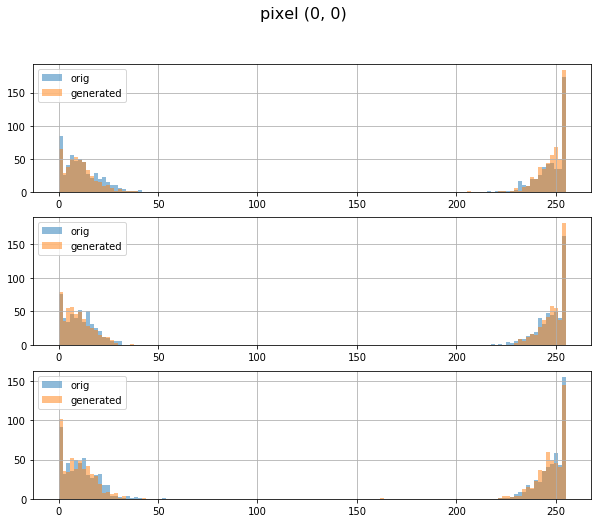

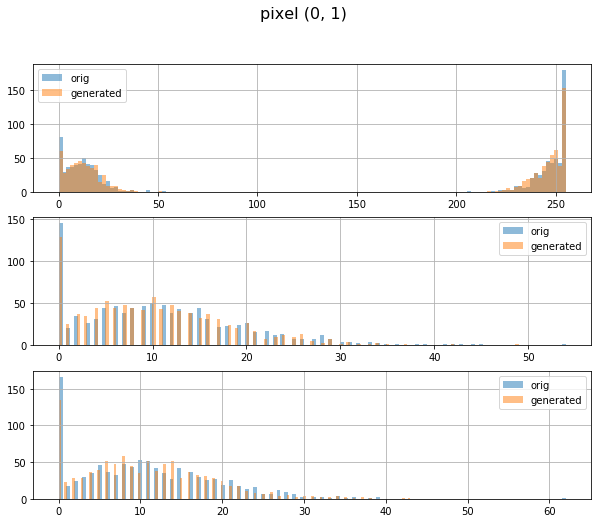

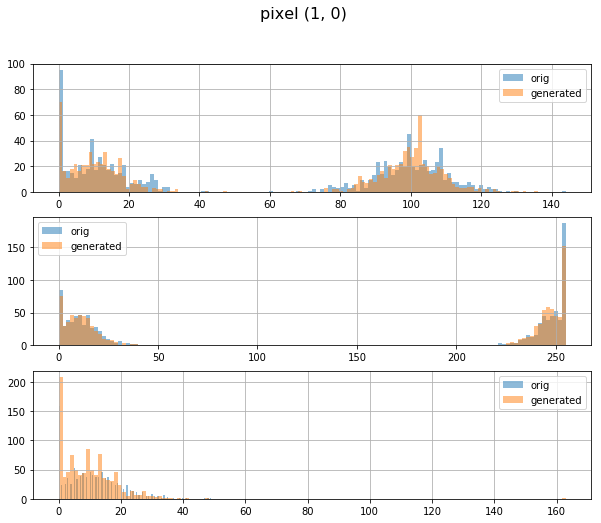

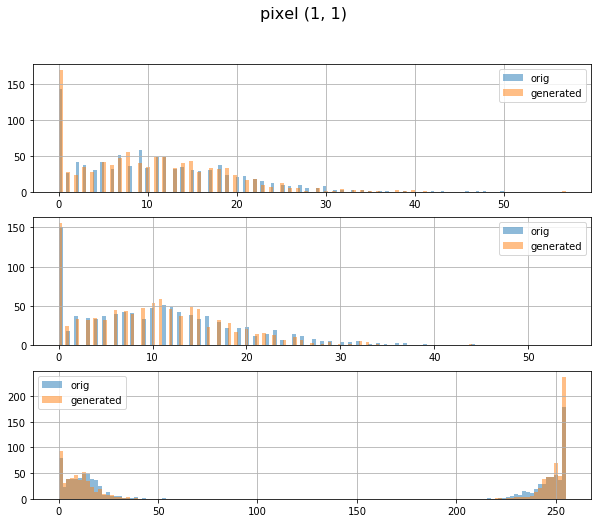

In [18]:
N = 1000

# Generated params 
x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
x_out = model.predict(x_sample, num_samples)

for i in range(img_cols):
    for j in range(img_rows):
        fig = plt.figure(figsize=(10,8), )
        fig.suptitle("pixel (%d, %d)" % (i, j), fontsize=16)
        for k in range(img_chns):
            ax = plt.subplot(img_chns, 1, k + 1)
            
            # Orig params
            ms = (params[0][i, j, k, :] - 127.5)  / 127.5
            invss = np.log(127.5 / params[1][i, j, k, :])
            weights = params[2][i, j, k, :]
            
            pvals_orig = compute_mixture(ms, invss, weights, n_comps=2)
            print(ms, invss, weights)
            pvals_orig /= pvals_orig.sum()
            samples = pd.Series(np.random.choice(len(pvals_orig), N, p=pvals_orig))
            samples.hist(bins=128, ax=ax, alpha=0.5, label='orig')
            
            # Generated params
            offset = k * n_components
            ms = x_out[n, i, j, offset:offset + n_components]
            offset = n_components * img_chns + k * n_components
            invss = x_out[n, i, j, offset:offset + n_components]
            offset = 2 * n_components * img_chns + k * n_components
            weights = softmax(x_out[n, i, j, offset:offset + n_components])
            
            pvals_gen = compute_mixture(ms, invss, weights, n_components)
            print(ms, invss, weights)
            pvals_gen /= pvals_gen.sum()
            samples = pd.Series(np.random.choice(len(pvals_gen), N, p=pvals_gen))
            samples.hist(bins=128, ax=ax, alpha=0.5, label='generated')
            
            ax.legend()
            print('KL Divergence(orig, gen) for (%d,%d,%d): %.2f' % (i, j, k, scipy.stats.entropy(pvals_orig, pvals_gen)))

# Notes



### 2019-03-03

Issues:
    
* Wrong order of RGB slices when repeating image
* Used old 255. value vs. 127.5
* Added non-zero init to param values
    
Next TODO:

* Plot histograms of 0 to 255 pixel values, somehow see that the mass is the same?
* Maybe KL divergence?

### 2019-03-07

 * It looks like my generated distributions are spreading too much mass over the range, which might be because I'm allowing the "invs" param to be small (< 1), which will naturally spread it very wide.  The model probably gets confused in these situations and finds a local minima that spreads it wide instead of using the power of the mixtures.  Maybe try to constrain it a bit more?
 
<img src="images/2019-03-07-spread.png">

 * Tried to make "invs" to be in range (2, 7), but it looks like it made the spreading worse.  It looks like these bimodal distributions aren't using the weights properly.  Maybe I need to debug my loss function?  The mixture maybe aren't being taken into account properly?


### 2019-03-25

Issues:

* Made minimum invss = 2.0 (by using `+2` in Lambda) so that we don't get distributions that are too diffuse
* Made weights initialized all at (1's) to get a more even spread


Comments:

<img src="images/2019-03-25-spread.png">

* I have a feeling that we can't recover the weights easily sometimes because the initalized weights (glorat_uniform) converges to a weird local minumum.  Makes sense b/c mixutre models in general won't converge to a global minimum through gradient descent.
    * Take a look at diagram: For the "G", "B" pixels, one of the mixtures looks pretty close, while the other isn't too bad (the "m" is too far to the left, so all the mass gets to the "0" pixel).  
    * However, for the "R" histogram, it converged to some bad local minima. You can see the mass is spread out so far.  The weight distribution is (0.95, 0.05) and the m is around (0.41,0.47) (in the middle).  This probably means that we found a local minima but it doesn't at all match the true distribution.
* Interesting, loss goes down to (27-ish) but KL diverge is relatively big for the distributions.  Makes sense since I'm not optimizing for KL divergence (in real life I have no idea what the distributions are.

Next TODO:

* Assuming that I can't converge to a global minimum (b/c of SGD doesn't allow it), maybe what I need is to have *over-capacity* (i.e. more mixture components) so I can find a good local minima that better approximates what I want.

# 2019-04-28

Finally found some time to work on it...

* Found a bug!  In the loss function, I was still using protection limits of [0.001, 0.999] but I rescaled things so it really should have been [-0.999, 0.999]
* I played around with different number of mixture components (while the source dataset still has 2 components) and I was right!  With only 2 components it's hard to model 2 components, but at 4/5, it gets pretty close (5 components):

<img src="images/2019-04-28-spread1.png">

However, the one pixel that has values that are closer together doesn't quite match:


<img src="images/2019-04-28-spread2.png">

Increasing the components to 10 seems to solve it:

<img src="images/2019-04-28-spread3-10comps.png">